<a href="https://colab.research.google.com/github/yashv04/Model-Debugging-Accuracy-Improvement/blob/main/Model_Debugging_%26_Accuracy_Improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Win Probability Predictor

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max.colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [51]:
deliveries = pd.read_csv('deliveries_till_2024.csv')
matches = pd.read_csv('matches_till_2024.csv')

In [52]:
df = deliveries.merge(matches, left_on='match_id', right_on='id')

In [53]:
df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN,335982,2007/08,Bangalore,18-04-2008,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen


In [54]:
# Drop rows with missing outcomes
df = df.dropna(subset=['winner', 'batting_team', 'bowling_team'])

# Target: 1 if batting_team won, else 0
df['win'] = (df['winner'] == df['batting_team']).astype(int)

In [57]:
# Basic match features
df['balls_bowled'] = df['over'] * 6 + df['ball']
df['balls_left'] = 120 - df['balls_bowled']
df['current_run_rate'] = df['total_runs'] / (df['balls_bowled'] / 6 + 1e-6)
df['required_run_rate'] = df['target_runs'] / (df['balls_left'] / 6 + 1e-6)
df['remaining_overs'] = df['balls_left'] / 6
df['wickets_left'] = 10 - df['is_wicket']

# Optional: Mark home advantage if available
df['is_home'] = df.apply(lambda row: int(row['batting_team'] in row['venue']), axis=1)

# Game phase bins
df['over_bin'] = pd.cut(df['over'], bins=[0,6,15,20], labels=['Powerplay','Middle','Death'])

# Encode categorical features
df = pd.get_dummies(df, columns=['over_bin', 'batting_team', 'bowling_team', 'venue'], drop_first=True)

In [58]:
# Build feature list dynamically
base_features = [
    'total_runs', 'wickets_left', 'balls_left', 'current_run_rate',
    'required_run_rate', 'remaining_overs', 'is_home'
]

# Add all one-hot encoded columns
encoded_features = [col for col in df.columns if col.startswith(('over_bin_', 'batting_team_', 'bowling_team_', 'venue_'))]

X = df[base_features + encoded_features]
y = df['win']

In [60]:
!pip install xgboost
from xgboost import XGBClassifier

Accuracy: 0.7862189455899858
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     26448
           1       0.79      0.77      0.78     25638

    accuracy                           0.79     52086
   macro avg       0.79      0.79      0.79     52086
weighted avg       0.79      0.79      0.79     52086



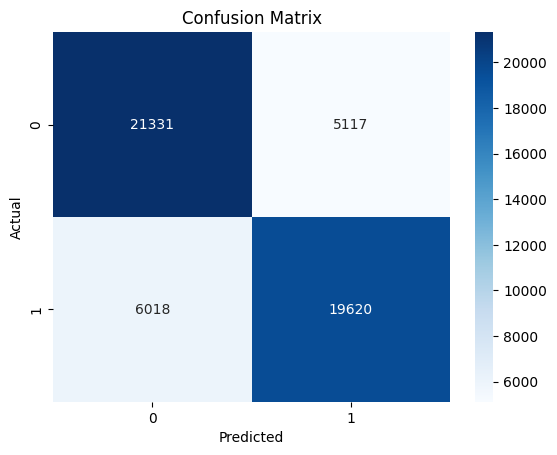

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [62]:
def predict_live_win_prob(total_runs, wickets_left, balls_left, target_runs, over, batting_team, bowling_team, venue):
    current_run_rate = total_runs / ((120 - balls_left) / 6 + 1e-6)
    required_rr = (target_runs - total_runs) / (balls_left / 6 + 1e-6)
    remaining_overs = balls_left / 6
    is_home = 1 if batting_team in venue else 0

    over_bin = 'Powerplay' if over <= 6 else 'Middle' if over <= 15 else 'Death'

    # Initialize input row
    input_row = {
        'total_runs': total_runs,
        'wickets_left': wickets_left,
        'balls_left': balls_left,
        'current_run_rate': current_run_rate,
        'required_run_rate': required_rr,
        'remaining_overs': remaining_overs,
        'is_home': is_home
    }

    # Set encoded features to 0
    for col in encoded_features:
        input_row[col] = 0

    # Activate relevant encoded features
    if f'over_bin_{over_bin}' in input_row: input_row[f'over_bin_{over_bin}'] = 1
    if f'batting_team_{batting_team}' in input_row: input_row[f'batting_team_{batting_team}'] = 1
    if f'bowling_team_{bowling_team}' in input_row: input_row[f'bowling_team_{bowling_team}'] = 1
    if f'venue_{venue}' in input_row: input_row[f'venue_{venue}'] = 1

    input_df = pd.DataFrame([input_row])
    win_prob = model.predict_proba(input_df)[0][1]
    return round(win_prob * 100, 2)

In [69]:
predict_live_win_prob(
    total_runs=110,
    wickets_left=5,
    balls_left=30,
    target_runs=209,
    over=15,
    batting_team='Chennai Super Kings',
    bowling_team='Royal Challengers Bangalore',
    venue='M. A. Chidambaram Stadium'
)

np.float32(46.25)

Simulate Win % Progression with Runs / Overs

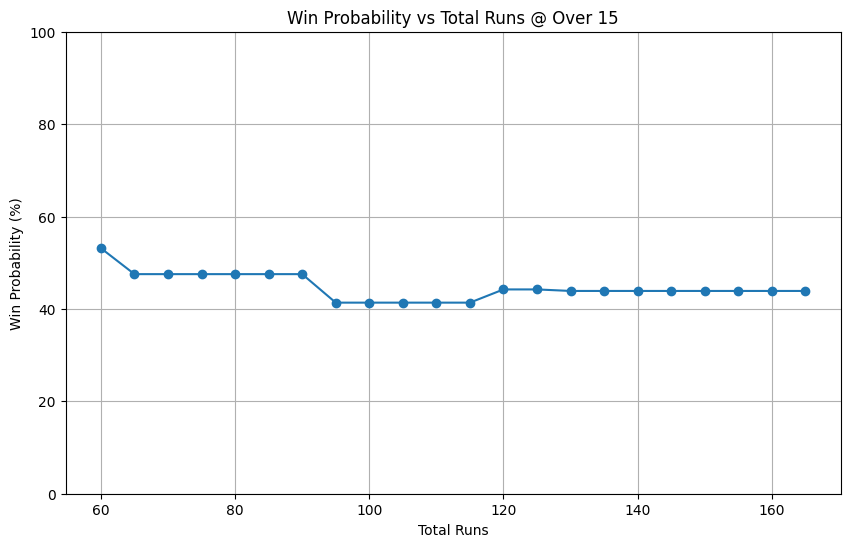

In [70]:
import matplotlib.pyplot as plt

def simulate_runs_vs_winprob(batting_team, bowling_team, venue, wickets_left, balls_left, target_runs, over):
    runs = list(range(60, target_runs + 20, 5))
    probs = [predict_live_win_prob(
        total_runs=r,
        wickets_left=wickets_left,
        balls_left=balls_left,
        target_runs=target_runs,
        over=over,
        batting_team=batting_team,
        bowling_team=bowling_team,
        venue=venue
    ) for r in runs]

    plt.figure(figsize=(10,6))
    plt.plot(runs, probs, marker='o')
    plt.title(f"Win Probability vs Total Runs @ Over {over}")
    plt.xlabel("Total Runs")
    plt.ylabel("Win Probability (%)")
    plt.grid(True)
    plt.ylim(0, 100)
    plt.show()

# Example usage
simulate_runs_vs_winprob(
    batting_team='Chennai Super Kings', bowling_team='Royal Challengers Bangalore', venue='M. A. Chidambaram Stadium',
    wickets_left=6, balls_left=30, target_runs=150, over=15
)

In [75]:
import joblib
joblib.dump(model, "xgb_model.pkl")
joblib.dump(encoded_features, "encoded_columns.pkl")

['encoded_columns.pkl']

In [72]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.5 MB/s eta 0:00:00


In [76]:
import gradio as gr
import joblib

model = joblib.load("xgb_model.pkl")
encoded_columns = joblib.load("encoded_columns.pkl")

def predict_win(total_runs, wickets_left, balls_left, target_runs, over, batting_team, bowling_team, venue):
    # insert your predict_live_win_prob function logic here
    prob = predict_live_win_prob(total_runs, wickets_left, balls_left, target_runs, over, batting_team, bowling_team, venue)
    return f"{prob:.2f}% Win Probability"

iface = gr.Interface(
    fn=predict_win,
    inputs=[
        gr.Number(label="Total Runs"),
        gr.Number(label="Wickets Left"),
        gr.Number(label="Balls Left"),
        gr.Number(label="Target Runs"),
        gr.Number(label="Over"),
        gr.Textbox(label="Batting Team"),
        gr.Textbox(label="Bowling Team"),
        gr.Textbox(label="Venue")
    ],
    outputs="text"
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cdf27041ce16d9ba5b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
